### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [3]:
train_dir = 'CornLeafDisease/CornData/train_corn'
validation_dir = 'CornLeafDisease/CornData/validation_corn'

In [4]:
os.system("rm -rf CornLeafDisease/CornData/train_corn/.ipynb_checkpoints")
os.system("rm -rf CornLeafDisease/CornData/validation_corn/.ipynb_checkpoints")

0

In [4]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            labels='inferred',
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 labels='inferred',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 7318 files belonging to 4 classes.
Found 1829 files belonging to 4 classes.


In [5]:
class_names = train_dataset.class_names
print(class_names)


['Blight', 'Healthy', 'Rust', 'Spot']


In [6]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 29
Number of train batches: 115


In [11]:
#rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetV2B2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [8]:
base_model.trainable = False

In [9]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4, activation='softmax')])

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 5, 5, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                22544     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 8,791,986
Trainable params: 22,612
Non-tra

In [12]:
loss0, accuracy0 = model.evaluate(validation_dataset)

29/29 [==============================] - 19s 572ms/step - loss: 1.5010 - accuracy: 0.2045


In [13]:
start = time.time()
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    verbose = 1)
end = time.time()
print(f"time elapsed: {(end-start)/60} minutes")

Epoch 1/10
115/115 [==============================] - 90s 725ms/step - loss: 0.8551 - accuracy: 0.6927 - val_loss: 0.4573 - val_accuracy: 0.8885
Epoch 2/10
115/115 [==============================] - 84s 729ms/step - loss: 0.3945 - accuracy: 0.8955 - val_loss: 0.2863 - val_accuracy: 0.9218
Epoch 3/10
115/115 [==============================] - 83s 723ms/step - loss: 0.2780 - accuracy: 0.9225 - val_loss: 0.2227 - val_accuracy: 0.9355
Epoch 4/10
115/115 [==============================] - 83s 721ms/step - loss: 0.2211 - accuracy: 0.9362 - val_loss: 0.1851 - val_accuracy: 0.9453
Epoch 5/10
115/115 [==============================] - 83s 725ms/step - loss: 0.1922 - accuracy: 0.9440 - val_loss: 0.1618 - val_accuracy: 0.9486
Epoch 6/10
115/115 [==============================] - 83s 725ms/step - loss: 0.1666 - accuracy: 0.9504 - val_loss: 0.1464 - val_accuracy: 0.9497
Epoch 7/10
115/115 [==============================] - 83s 726ms/step - loss: 0.1508 - accuracy: 0.9538 - val_loss: 0.1363 - val_ac

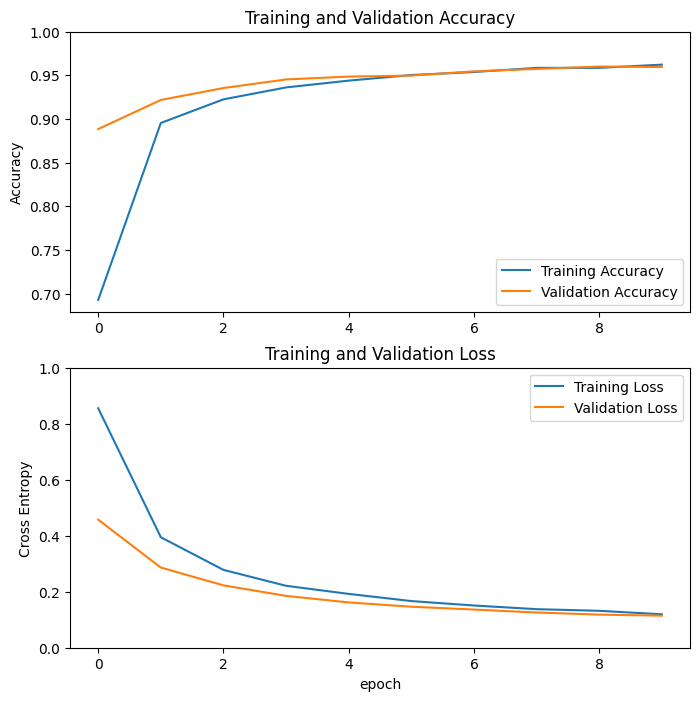

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
base_model.trainable = True

In [16]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 300

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  349


In [17]:
final_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=final_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 5, 5, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                22544     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 8,791,986
Trainable params: 2,318,992
Non-

In [19]:
start = time.time()
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

end = time.time()
print(f"time elased: {(end - start)/60} minutes")

Epoch 10/20
115/115 [==============================] - 111s 886ms/step - loss: 0.1750 - accuracy: 0.9557 - val_loss: 0.1424 - val_accuracy: 0.9546
Epoch 11/20
115/115 [==============================] - 100s 871ms/step - loss: 0.1470 - accuracy: 0.9575 - val_loss: 0.1261 - val_accuracy: 0.9579
Epoch 12/20
115/115 [==============================] - 104s 904ms/step - loss: 0.1265 - accuracy: 0.9656 - val_loss: 0.1146 - val_accuracy: 0.9595
Epoch 13/20
115/115 [==============================] - 103s 894ms/step - loss: 0.1136 - accuracy: 0.9682 - val_loss: 0.1114 - val_accuracy: 0.9601
Epoch 14/20
115/115 [==============================] - 100s 874ms/step - loss: 0.1061 - accuracy: 0.9703 - val_loss: 0.1024 - val_accuracy: 0.9601
Epoch 15/20
115/115 [==============================] - 100s 874ms/step - loss: 0.0991 - accuracy: 0.9717 - val_loss: 0.0958 - val_accuracy: 0.9634
Epoch 16/20
115/115 [==============================] - 100s 873ms/step - loss: 0.0940 - accuracy: 0.9727 - val_loss: 0

In [20]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

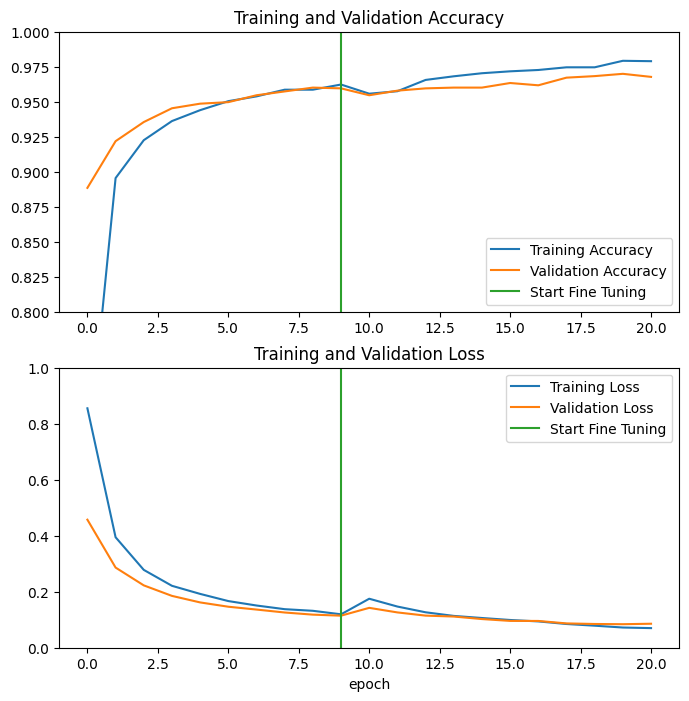

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 10)

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

2/2 [==============================] - 1s 581ms/step - loss: 0.0824 - accuracy: 0.9688
Test accuracy : 0.96875
Test loss : 0.08244848251342773
